In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_cos_glm import Sub_Cos_GLM
#from models.sub_tcn import Sub_TCN
#from models.gru import GRU
#from models.tcn_multilayer import TCN_Multilayer
#from models.lstm import LSTM
#from models.tcn import TCN
#from models.sub_cos_tcn import Sub_Cos_TCN
#from models.cos_tcn import Cos_TCN
#from models.gru_exp import GRU
#from models.gru_stacked import GRU_Stacked

In [2]:
base_dir = "/scratch/yjk27/"
experiment = "NA_NMDA"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file  = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.6_Ni200_gG0.1_gB0.06_NA0.75_NMDA0.75_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1_set1.npy"
V_file = "V_diff_NA1.5_NMDA0.75_stimseed1.npy"

#E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
#I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
E_neural = scipy.sparse.load_npz(base_dir+"CA1_clust4-60/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+"CA1_clust4-60/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
#V -= torch.mean(V)

"""
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1_set1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1_set1.npy"
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)
"""

#####
#V_test_raw = np.load("/media/hdd01/sklee/"+experiment+"/data/V_diff_stimseed1.npy")
#V_test_raw = torch.from_numpy(V_test_raw)
#V_test_raw -= torch.mean(V_test_raw)

#test_E_neural_raw = scipy.sparse.load_npz("/media/hdd01/sklee/"+experiment+"/data/Espikes_neural.npz")
#test_I_neural_raw = scipy.sparse.load_npz("/media/hdd01/sklee/"+experiment+"/data/Ispikes_neural.npz")
#####

C_syn_e = np.load(base_dir+"CA1_clust4-60"+"/data/handsub1_C_syn_e.npy")
C_syn_i = np.load(base_dir+"CA1_clust4-60"+"/data/handsub1_C_syn_i.npy")
C_syn_e = torch.from_numpy(C_syn_e).float()
C_syn_i = torch.from_numpy(C_syn_i).float()

#C_syn_e = C_syn_e[:,e_idx]
#C_syn_i = C_syn_i[:,i_idx]

In [3]:
T_train = 980 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 1
#sub_no = 1
E_no = 2000
I_no = 200
#E_no = e_idx.shape[0]
#I_no = i_idx.shape[0]
T_no = 500
#T_no = 350
device = torch.device("cuda:0")

#layer_no = 3

increment = 50
batch_length = 50000
batch_size = 5
iter_no = 9800*2
epoch_no = iter_no*batch_length*batch_size//T_train

In [4]:
V_train = V[:T_train].float()
V_test = V[-50000:].to(device).float()

#V_test = V_test_raw[50000*993:50000*994].to(device).float()

test_E_neural = E_neural[-50000:].toarray()
test_I_neural = I_neural[-50000:].toarray()
#test_E_neural = E_neural[50000*993:50000*994].toarray()
#test_I_neural = I_neural[50000*993:50000*994].toarray()
#test_E_neural = test_E_neural_raw[50000*993:50000*994].toarray()
#test_I_neural = test_I_neural_raw[50000*993:50000*994].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
model = Sub_Cos_GLM(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
#model = GRU(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = GRU_Stacked(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = Sub_TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
#model = LSTM(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, layer_no, device)
#model = Sub_Cos_TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, layer_no, device)
#model = Cos_TCN(E_no, I_no, T_no, H_no, layer_no, device)
#model = TCN_Multilayer(T_no-1, 2200, layer_no, H_no, device)

# GLM (1.025 for V_diff, 1 for noNA)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1.035**100))
milestones = np.arange(increment-1, increment*100, increment)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1.035)

# GRU (1 for V_diff, 1 for noNA)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1**100))
#milestones = np.arange(increment-1, increment*100, increment)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1)

#TCN multilayer
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025,
                             #weight_decay=0.0000001) # for TCNMUlti
                             #weight_decay=0)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

2263


In [6]:
score_list = np.empty((iter_no))

for i in tnrange(iter_no):
#for i in tnrange(12000):
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred, _, _ = model(batch_E_neural, batch_I_neural)
    #V_pred, _ = model(batch_E_neural[:,5000:35000,e_idx], batch_I_neural[:,5000:35000,i_idx])
    #V_pred = model(batch_E_neural, batch_I_neural)
    
    train_score = explained_variance_score(batch_V[:,:].flatten().cpu().detach().numpy(),
                                           V_pred.flatten().cpu().detach().numpy())
    
    loss = torch.mean((V_pred- batch_V[:,:] )**2)
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_sub_out, _ = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        #test_V_pred, test_sub_out = model(test_E_neural.unsqueeze(0)[:,5000:35000,e_idx], test_I_neural.unsqueeze(0)[:,5000:35000,i_idx])
        #test_V_pred = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy()[:], test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[:]-test_V_pred)**2).item()
        score_list[i//50] = test_score
                
        print(i, np.round(test_score,6),
              np.round(train_score,6))


<ipython-input-6-a1715703122f>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 -0.023967 -0.032636
49 -0.011682 -0.017265
99 -0.004058 -0.007291
149 0.002566 -0.00347
199 0.007205 0.00861
249 0.010214 0.010258
299 0.01271 0.012366
349 0.015308 0.016545
399 0.018068 0.020617
449 0.021208 0.030248
499 0.024435 0.028423
549 0.028292 0.030279
599 0.031949 0.044461
649 0.035696 0.058148
699 0.039516 0.052486
749 0.043309 0.058441
799 0.046688 0.05852
849 0.050046 0.063382
899 0.053564 0.065512
949 0.056433 0.075221
999 0.059838 0.071883
1049 0.063167 0.082046
1099 0.066354 0.081511
1149 0.069099 0.08093
1199 0.072262 0.091783
1249 0.075101 0.104308
1299 0.077964 0.087283
1349 0.081359 0.093325
1399 0.083992 0.092912
1449 0.08598 0.104222
1499 0.089355 0.115084
1549 0.091941 0.115092
1599 0.094848 0.116136
1649 0.096956 0.120831
1699 0.098858 0.116795
1749 0.102007 0.116676
1799 0.10461 0.13107
1849 0.106061 0.126334
1899 0.109095 0.135347
1949 0.11117 0.137398
1999 0.114102 0.144675
2049 0.116167 0.142235
2099 0.118395 0.135073
2149 0.120692 0.142321
2199 0.121984 0

17699 0.273258 0.308759
17749 0.271247 0.308225
17799 0.272961 0.305345
17849 0.272671 0.297673
17899 0.272596 0.316522
17949 0.272678 0.330455
17999 0.272835 0.315883
18049 0.272476 0.308841
18099 0.27232 0.301973
18149 0.27256 0.298361
18199 0.27204 0.297126
18249 0.27301 0.295169
18299 0.273258 0.300908
18349 0.273226 0.31012
18399 0.272907 0.307152
18449 0.274016 0.286691
18499 0.273473 0.288463
18549 0.273207 0.309282
18599 0.272887 0.308323
18649 0.273386 0.285104
18699 0.272351 0.324325
18749 0.272762 0.304745
18799 0.271874 0.294629
18849 0.272807 0.294534
18899 0.272575 0.328721
18949 0.27287 0.284059
18999 0.273367 0.294106
19049 0.274251 0.306584
19099 0.273662 0.300313
19149 0.271854 0.282932
19199 0.271763 0.311433
19249 0.272579 0.337903
19299 0.273569 0.30186
19349 0.271938 0.298693
19399 0.273644 0.283995
19449 0.273779 0.326841
19499 0.272484 0.287689
19549 0.272769 0.290262
19599 0.273608 0.320763


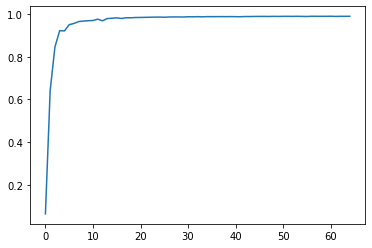

In [9]:
plt.plot(score_list[:65])
#plt.ylim(0,1)

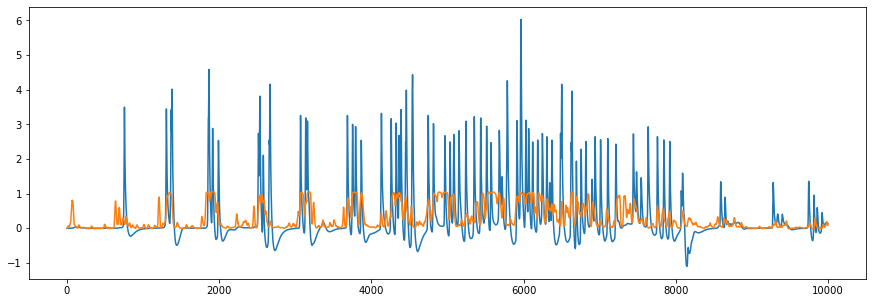

In [7]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[17000:27000])
plt.plot(test_V_pred.cpu().detach().numpy()[17000:27000])

In [8]:
#torch.save(model.state_dict(), "/scratch/yjk27/CA1_NA_NMDA/NA1.5_NMDA0.75/na_glm_s1_h1.pt")